# <center>Network Science</center>

## <center/>Course Project #2

### <center>Student: *Salnikov Alexander*</center>

#### <hr /> General Information

**Due Date:** 17.06.2016 23:59 <br \>
**Late submission policy:** no grade <br \>


Please send your reports to <mailto:network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2016] *Alexander* *Salnikov* Project*2***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

## Description

### Data

As a dataset to analyse you can choose one option in the following list:
1. Real Dataset (can be found [here](http://snap.stanford.edu/) or [here](http://konect.uni-koblenz.de/networks/))
2. Generated Dataset. Use more complex structure rather than just a simple ER model. For instance, you may consider multilevel network, where on the lower level you have several Watts-Strogatz graphs and on the upper level these graphs are respesented as randomly connected nodes.
3. Your data mined from Social Networks, Twitter, LiveJournal e.t.c.

**The order of your dataset should be no less than $10^4$ nodes**

### Models

Consider one of the following models:
1. SIR-based (or another with more than 3 letters) epidemic model
2. Independent Cascade Model
3. Linear Threshold Model

### Tasks

#### Network Descriptive Analysis

Provide information on your netowork: Source, Descriptive Statistics, Visualization

Chosen dataset is http://konect.uni-koblenz.de/networks/ego-twitter. This directed networks contains Twitter user–user following information. A node represents a user. An edge indicates that the user represented by the left node follows the user represented by the right node.

Since the project is specific to time of execution let's install an ipython extensions that shows time of execution of every cell

In [162]:
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.13 ms


Now let's import this network as a graph and provide some initial descriptive analyics.

In [209]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.read_edgelist("out.ego-twitter", delimiter=" ",comments="%",nodetype=int)

A = np.array(nx.adjacency_matrix(G).todense())
n = A.shape[0]
deg = np.sum(A,axis=0, dtype=float) # scope out


time: 14.1 s


Total number of nodes: 23370
Total number of edges: 32831
Max node degree: 238
Average node degree: 2.809670517757809


PDF and cCDF of graph respectfully


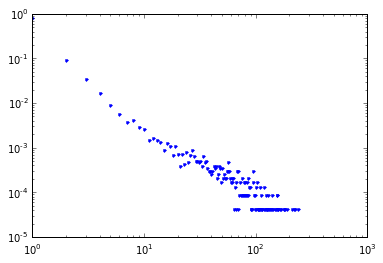

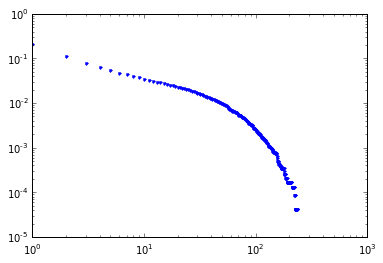

time: 1.97 s


In [218]:
def get_node_degrees(g, direction=None):
    if direction == "in":
        return np.array(list(g.in_degree().values()), dtype=np.int)
    elif direction == "out":
        return np.array(list(g.out_degree().values()), dtype=np.int)
    else:
        return np.array(list(g.degree().values()), dtype=np.int)


def get_pdf(node_degrees):
    node_bincount_as_float = np.bincount(node_degrees).astype(float)
    return node_bincount_as_float/len(node_degrees)


def get_cdf(pdf):
    return np.cumsum(pdf)

print("Total number of nodes: {}".format(len(G.nodes())))
print("Total number of edges: {}".format(len(G.edges())))
node_degrees = get_node_degrees(G)
print("Max node degree: {}".format(np.max(node_degrees)))
print("Average node degree: {}".format(np.average(node_degrees)))

print("\n\nPDF and cCDF of graph respectfully")
plt.loglog(get_pdf(node_degrees),"b.")
plt.figure()
plt.loglog(1-get_cdf(get_pdf(node_degrees)),"b.")

#### Main Task for models (2-3)

You are running the marketing campaign for brand new pocket device. Initially you can sign contracts with a few people to advertize your gadget among their neigbours. The more "famous" person you are picking the greater price appears in the contract.
* Contract cost can be calculated as $300 \$ \times \text{NN}(i)$, where $\text{NN}(i)$ is size of the neigbourhood of the person $i$.
* You earn $250\$$ per each affected person

Your task is to maximize your influence and maximize profit of your campaign

Linear Threshold Model was chosed for this task. It requires definition of a treshold for each individual. Since treshold depends from personality let's randomize it throug network uniformly from 0 to 1.

In [160]:
theta = np.random.random_sample(n)

time: 11.7 ms


Introduce function that returns influenced users after propagation, depending on the initial set of users. That's a slightly modified version from seminar. `deg` calculation is scoped-out to the global namespace to prevent it's recalculation on every iteration of greedy algorythm.

In [161]:
def InfluenceProp(A, initActive, theta, itersNum = np.inf):
    i = 1 # iteration
    resActive = initActive.copy()    
    while i < itersNum:
        i+=1

        # currently inactive nodes
        inactiveId = np.where(resActive == 0)[0]    
        # activated nodes
        idx = np.sum(A[np.ix_(resActive==1, resActive==0)], axis=0) / deg[resActive==0] > theta[inactiveId]
        if np.any(idx):
            resActive[inactiveId[idx]] = 1
        else:
            break

    return resActive

time: 14 ms


In [62]:
def LenInfluenceProp(A, initActive, theta, itersNum = np.inf):
    resultActive = InfluenceProp(A, initActive, theta, itersNum=itersNum)
    return len(np.where(resultActive==True)[0])

Now let's introduce a greedy algorythm realization of intial set of nodes optimization. Tip of keeping sorted list of marginal gains and recalculate only top of it on every step is used.

The idea of stop is when top node gives a marginal gain 1 or 0 or ex

In [228]:
def greedy(A, theta, iterStop, itersNum = np.inf, return_value = "nodes"):
    n = A.shape[0]
    InitActive = np.zeros((n,), dtype=bool)
    marginal_gain = np.zeros((n,2), dtype=int)
    marginal_gain[:,0] = range(n)
    result = []
    current_influence = 0
    step = 1
    while True:
        # calc marginal gain for all nodes on first step
        top_to_recalculate = range(n) if step == 1 else range(10) 
        for i in top_to_recalculate:
            tempInitActive = InitActive.copy()
            tempInitActive[marginal_gain[i,0]] = 1
            marginal_gain[i,1] = LenInfluenceProp(A, tempInitActive, theta, itersNum=itersNum)- current_influence
        
        marginal_gain = marginal_gain[marginal_gain[:,1].argsort()][::-1]

        
        InitActive[marginal_gain[0,0]] = 1
        result.append(marginal_gain[0,0])
        
        # speed up a little by adding influenced guys to an initial set.|
        InitActive = InfluenceProp(A, InitActive, theta, itersNum=itersNum)
        current_influence = len(np.where(InitActive==True)[0])
        
            
        if step == iterStop or step == n or marginal_gain[0,1]==1 or marginal_gain[0,1]==0:
            break

        marginal_gain[0,1] = -1 # make sure this node will never be on top anymore
        marginal_gain = marginal_gain[marginal_gain[:,1].argsort()][::-1]
        

        step = step +1

    if return_value == "marginal_gain":
        return marginal_gain
    else:
        return result

time: 34.2 ms


The first 5 nodes, returned by greedy algorythm are giving propagation of 1078 nodes.

In [260]:
#idx = [2676, 11823, 23023, 379, 14612]
idx = [11823]
initActive = np.zeros((n,), dtype=bool)
initActive[idx] = 1

time: 2.17 ms


In [261]:
resultActive = InfluenceProp(A, initActive, theta)
print(len(np.where(resultActive==True)[0]))

237
time: 235 ms


In [256]:
print(list(G.degree().values())[11822])
print(G.degree()[11823])
print(deg[[2676, 11823, 23023, 379, 14612]-1])

4
4


TypeError: unsupported operand type(s) for -: 'list' and 'int'

time: 37.6 ms


Greedy algorythm is correct and performance boosting tips are used, but execution still take a long time. 
My calculations shows that for 22k nodes it took a couple of days, that is doable in general.

But for continue of research we need something faster. 
There is an idea to use list of nodes ordered by some centrality metric.
Also that makes sence to try the order obtained from the very first iteration of greedy algorythm.

In [233]:
greedy_ordered_list = greedy(A, theta,1, return_value="marginal_gain")[:,0]

time: 37.4 s


Let's introduce a function that calculates our profit given by list of initial nodes we sign a contract with:

In [263]:
def get_profit(init_nodes_idx):
    cost = 300*np.sum(deg[np.array(init_nodes_idx)-1]) # -1 since that indexes starts from 0 and node names form 1
    initActive = np.zeros((n,), dtype=bool)
    initActive[init_nodes_idx] = 1
    profit = 250*LenInfluenceProp(A, initActive, theta)
    return profit-cost
    

time: 4.34 ms


Not let's build a set of pair, using N top of greedy_ordered_list and each profit

In [293]:
profits = []
for i in range(1,19):
    profits.append(get_profit(greedy_ordered_list[0:i]))

time: 32.4 s


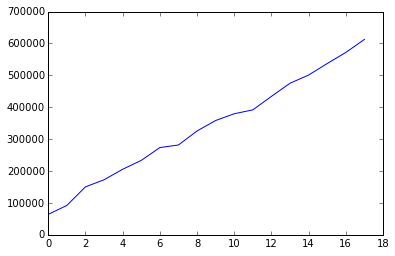

time: 284 ms


In [294]:
plt.plot(profits)

As we can see profit increases with growth of number of initial nodes. That is predictable, but the grow will stop when cost of new added node became more than gained profit. Basicly that will happen when magrinal gain of the guy will be equal or less than it's degree. Since 300>250. 
And marginal gain decreases with i according to ordering with greedy algorythm.
Unfortunately computations still takes too long so i wasn't able to build overall plot.

In [292]:
print("But we have achieved profit of {} USD, that's pretty good=)".format(profits[-1]))

But we have achieved profit of 571950.0 USD, that's pretty good=)
time: 1.49 ms


990 nodes brings us 

In [311]:
get_profit(greedy_ordered_list[0:990])

4518150.0

time: 12 s


995 nodes bring us less

In [316]:
get_profit(greedy_ordered_list[0:995])

4517500.0

time: 9.1 s


Let's try to find exact number

In [318]:
get_profit(greedy_ordered_list[0:991])

4522300.0

time: 5.5 s


In [317]:
get_profit(greedy_ordered_list[0:992])

4522000.0

time: 6.83 s


In [319]:
get_profit(greedy_ordered_list[0:993])

4521700.0

time: 5.61 s


In [320]:
get_profit(greedy_ordered_list[0:994])

4521400.0

time: 6.07 s


So the maximum is probably achieved at using TOP 991 nodes from the first iteration of greedy algorythm and gives us 4522300 USD.

More sophisticated and precise number can be achieved by letting greedy algorythm finish and finding exact maximum on all sorted list.